# Statistical prediction of synthetic data

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
def trend(time, slope=0):
    return slope * time

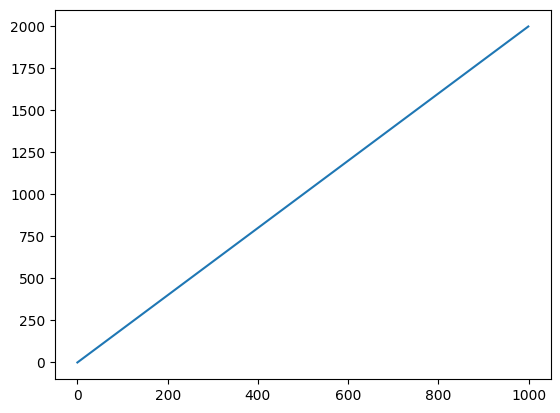

In [4]:
fig = plt.figure()
time = np.arange(0, 1000, 1)
y = trend(time, slope=2)
plt.plot(time, y);

In [5]:
def seasonal_pattern(season_time, a=0.4):
    return np.where(season_time < a, np.cos(2 * season_time * np.pi), 1/np.exp(3 * season_time))

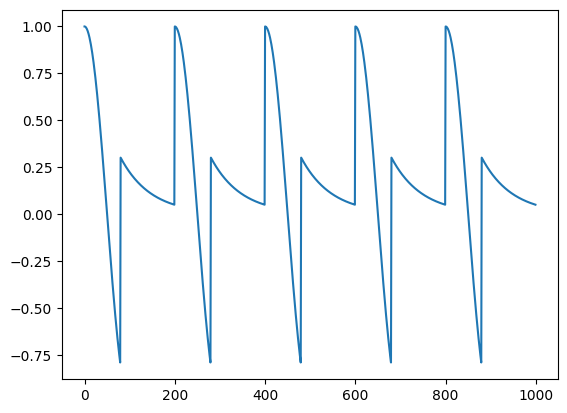

In [6]:
plt.figure()
period = 200
seasonal_time = (time % period) / period
y = seasonal_pattern(seasonal_time)
plt.plot(time, y)

In [7]:
def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

In [8]:
def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

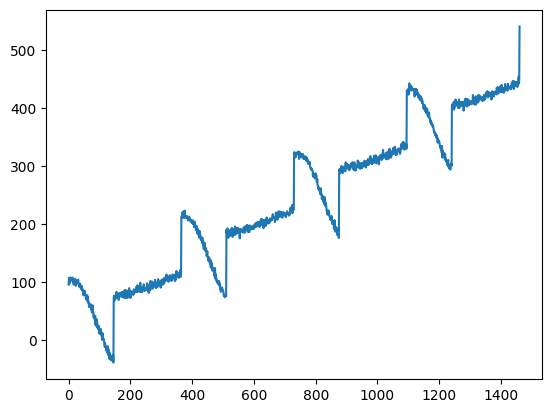

In [9]:
baseline = 2
amptitude = 100
noise_level = 4
slope = 0.3
period = 365
phase=0

time = np.arange(4 * 365 + 1, dtype='float32')

series = baseline + noise(time, noise_level) + trend(time, slope) + seasonality(time, period, amptitude, phase)

plt.figure()
plt.plot(time, series)

# Split the data

In [10]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

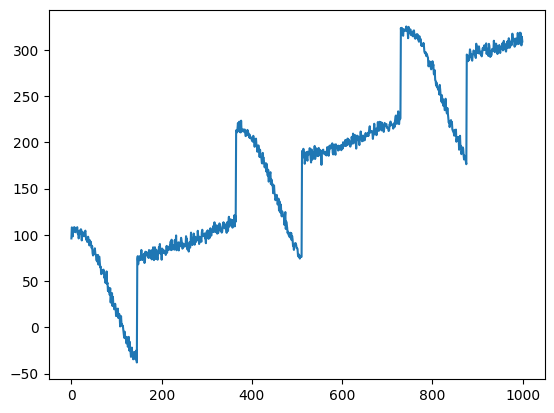

In [11]:
plt.plot(time_train, x_train);

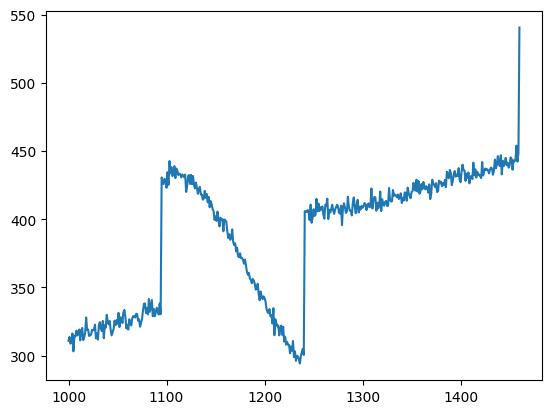

In [12]:
plt.plot(time_valid, x_valid)

## Naive forcasting

Naive forcasting assumes that the next value to predict is the same as the previous one

In [13]:
naive_series = series[split_time - 1:-1]

time_step = 100

print(f'Ground truth for time step {time_step} is {x_valid[time_step]}')
print(f'Predicted for time step {time_step + 1} is {naive_series[time_step + 1]}')

Ground truth for time step 100 is 423.04795309034574
Predicted for time step 101 is 423.04795309034574


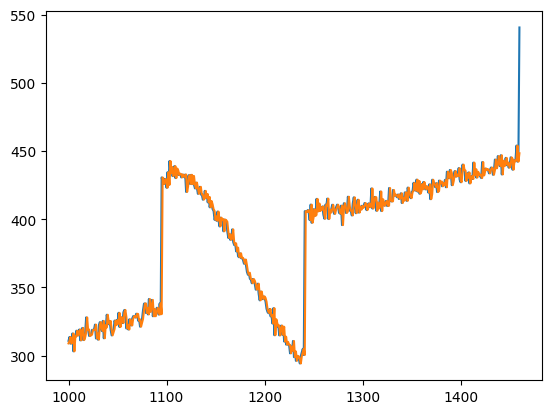

In [14]:
plt.plot(time_valid, x_valid)
plt.plot(time_valid, naive_series)

In [15]:
print(tf.keras.metrics.mean_squared_error(x_valid, naive_series).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_series).numpy())

95.92322048072937
5.118696986287924


## Moving average

In [16]:
def moving_average(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

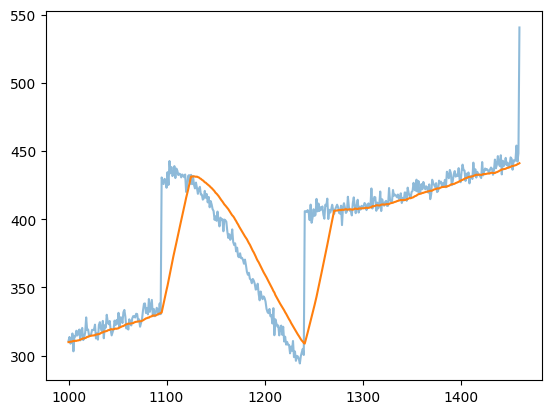

In [17]:
mov_avg = moving_average(series, 30)[split_time - 30:]
plt.plot(time_valid, x_valid, alpha=0.5);
plt.plot(time_valid, mov_avg);

In [20]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, mov_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, mov_avg).numpy())

577.8950788447522
13.82452804869449


### Differencing

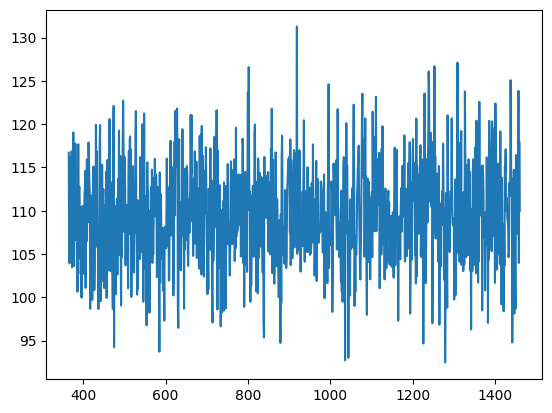

In [21]:
# Subtract the values at t-365 from original series
diff_series = (series[365:] - series[:-365])

# Truncate the first 365 time steps
diff_time = time[365:]

# Plot the results
plt.plot(diff_time, diff_series)

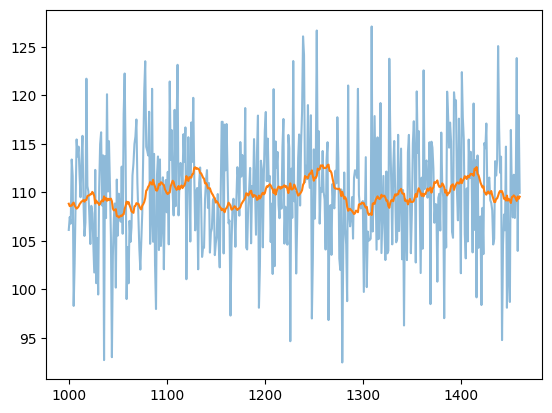

In [22]:
mov_avg_diff = moving_average(diff_series, 30)
# Slice the prediction points that corresponds to the validation set time steps
mov_avg_diff = mov_avg_diff[split_time - 365 - 30:]

# Slice the ground truth points that corresponds to the validation set time steps
diff_series = diff_series[split_time - 365:]

plt.plot(time_valid, diff_series, alpha=0.5);
plt.plot(time_valid, mov_avg_diff);

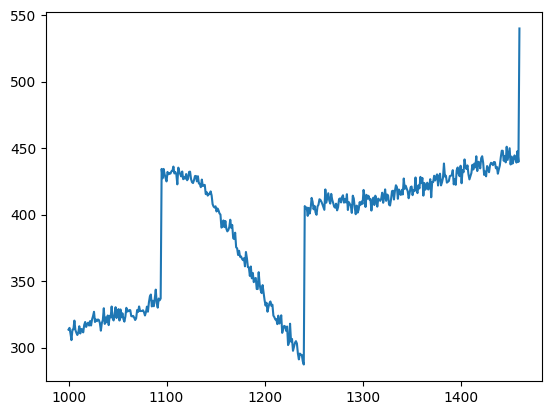

In [23]:
# Add the trend and seasonality from the original series
diff_moving_avg_plus_past = series[split_time - 365:-365] + mov_avg_diff
plt.plot(time_valid, diff_moving_avg_plus_past);

In [24]:
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

36.495252246649265
4.716214213629336
